In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_utils import Dataset

## Create train and test datasets

Find all the raw data files and build train and test Dataset objects from the patients' scans. 

In [2]:
# get file paths to DICOM MRI and segmentation images, note that leaderboard samples can be used for training
train_scan_files = glob('../data/raw/train/**/*.dcm', recursive=True)
train_scan_files += glob('../data/raw/leaderboard/**/*.dcm', recursive=True)
test_scan_files = glob('../data/raw/test/**/*.dcm', recursive=True)

# ProstateDx-01-0006_corrected_label.nrrd was renamed to ProstateDx-01-0006.nrrd
# In the leaderboard and test folders the _truth postfix have been removed from all nrrd files
train_seg_files = glob('../data/raw/train/**/*.nrrd', recursive=True)
train_seg_files += glob('../data/raw/leaderboard/**/*.nrrd', recursive=True)
test_seg_files = glob('../data/raw/test/**/*.nrrd', recursive=True)

# build datasets from file paths
train_dataset = Dataset(scan_files=train_scan_files, seg_files=train_seg_files)
test_dataset = Dataset(scan_files=test_scan_files, seg_files=test_seg_files)

## Check basic stats
Check number of patients in train and test datasets.

In [3]:
train_n = len(train_dataset.patient_ids)
test_n = len(test_dataset.patient_ids)
train_scan_nums = [train_dataset.patients[p].scans.shape[0] for p in train_dataset.patient_ids]
test_scan_nums = [test_dataset.patients[p].scans.shape[0] for p in test_dataset.patient_ids]

print('Number of patients in train dataset: %d' % train_n)
print('Number of patients in test dataset: %d' % test_n)
print('Number of scans in train dataset: %d' % sum(train_scan_nums))
print('Number of scans in test dataset: %d' % sum(test_scan_nums))

Number of patients in train dataset: 70
Number of patients in test dataset: 10
Number of scans in train dataset: 1816
Number of scans in test dataset: 271


Check distribution of number of scans in train and test datasets.
- They both seem bi-modal with roughly the same peaks. 

(array([5., 0., 0., 0., 0., 0., 1., 3., 0., 1.]),
 array([19. , 21.1, 23.2, 25.3, 27.4, 29.5, 31.6, 33.7, 35.8, 37.9, 40. ]),
 <a list of 10 Patch objects>)

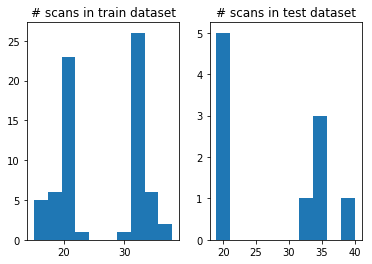

In [4]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('# scans in train dataset')
ax[0].hist(train_scan_nums, bins=10)
ax[1].set_title('# scans in test dataset')
ax[1].hist(test_scan_nums, bins=10)

Make sure that none of the patients have scans from mixed manufacturers and with mixed slice thickness.

In [5]:
# extract manufacturer and thickness sets from each patient
train_manufacturers = [train_dataset.patients[p].manufacturers for p in train_dataset.patient_ids]
train_thicknesses = [train_dataset.patients[p].thicknesses for p in train_dataset.patient_ids]
test_manufacturers = [test_dataset.patients[p].manufacturers for p in test_dataset.patient_ids]
test_thicknesses = [test_dataset.patients[p].thicknesses for p in test_dataset.patient_ids]

# check if any patient has slices from two different manufacturers or thicknesses - NO
for m in train_manufacturers + test_manufacturers:
    assert len(m) == 1

for t in train_thicknesses + test_thicknesses:
    assert len(t) == 1

- Looks like the test and train datasets have been properly stratified with respect to manufacturer, i.e. half of the sample are from Siemens and half of them are from Philips.
- However, the test dataset doesn't have slices of 4mm thickness.
- Philips is the higher resolution machine, all scans are rectangular. 

In [6]:
# collapse all list of sets to simple list
train_manufacturers = [list(i)[0] for i in train_manufacturers]
train_thicknesses = [list(i)[0] for i in train_thicknesses]
test_manufacturers = [list(i)[0] for i in test_manufacturers]
test_thicknesses = [list(i)[0] for i in test_thicknesses]

# extract scan width and height
train_widths = [train_dataset.patients[p].scans.shape[1] for p in train_dataset.patient_ids]
train_heights = [train_dataset.patients[p].scans.shape[2] for p in train_dataset.patient_ids]
test_widths = [test_dataset.patients[p].scans.shape[1] for p in test_dataset.patient_ids]
test_heights = [test_dataset.patients[p].scans.shape[2] for p in test_dataset.patient_ids]

# calculate contingency table from them
df_summary = pd.DataFrame(
    list(
        zip(
            train_dataset.patient_ids + test_dataset.patient_ids,
            train_manufacturers + test_manufacturers,
            train_thicknesses + test_thicknesses,
            train_widths + test_widths,
            train_heights + test_heights,
            ['train'] * train_n + ['test'] * test_n
        )
    ), 
    columns = ['patient_id', 'manufacturer', 'thickness', 'width', 'heigth', 'dataset']
)

df_summary.drop(['width', 'heigth'], axis=1).groupby(['dataset', 'manufacturer', 'thickness']).count()

patient_id
dataset manufacturer            thickness            
test    Philips Medical Systems 3                   5
        SIEMENS                 3                   5
train   Philips Medical Systems 3                  35
        SIEMENS                 3                  29
                                4                   6

In [7]:
df_summary.drop(['thickness'], axis=1).groupby(['dataset', 'manufacturer', 'width', 'heigth']).count()

patient_id
dataset manufacturer            width heigth            
test    Philips Medical Systems 400   400              5
        SIEMENS                 384   384              5
train   Philips Medical Systems 400   400             33
                                432   432              1
                                512   512              1
        SIEMENS                 256   256              1
                                320   320             29
                                384   384              5

## Visualise scans

Each patient's scans can be viewed as an animation or as a tiled figure. Let's have a look at some of these.

**Note** you'll need to re-execute the cell to watch the animation.

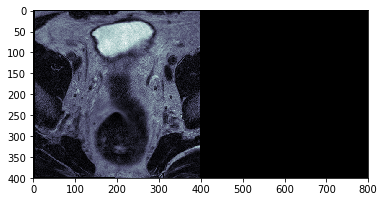

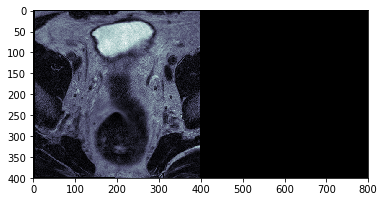

In [8]:
# animation
patient_id = train_dataset.patient_ids[33]
train_dataset.patients[patient_id].anim_scans()

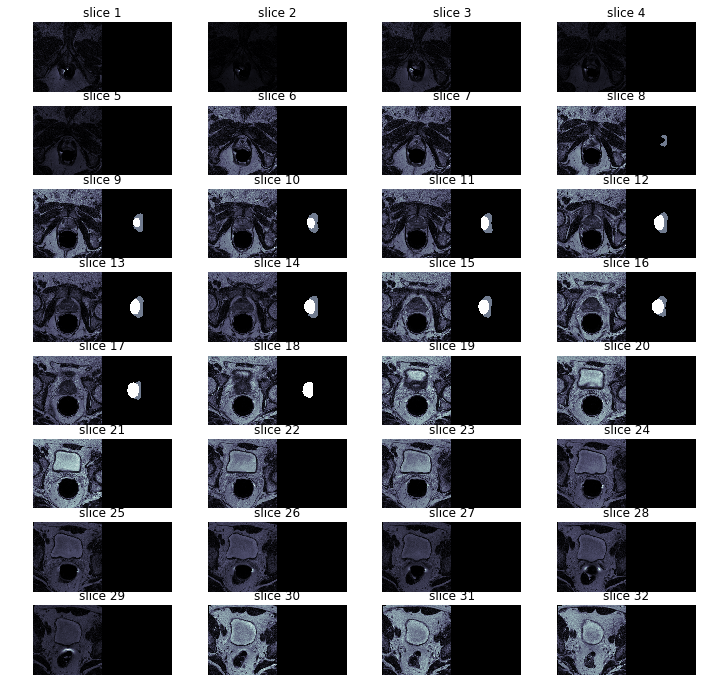

In [9]:
# tiled figure
patient_id = train_dataset.patient_ids[23]
train_dataset.patients[patient_id].show_scans()